# model TPH

In [1]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import re
from dateutil.parser import parse
import string
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_percentage_error
import missingno as msno
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
import scipy
import researchpy as rp
from matplotlib.offsetbox import AnchoredText
import pacmap
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import plotly.express as px
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split 
# Import Halving Grid Search
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
import xgboost as xgb
from scipy.stats import kurtosis,skew
from numpy import mean,sqrt,square
from scipy.fftpack import fft, fftfreq
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import PredefinedSplit
sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 100

In [2]:
# read df full csv
df_features=pd.read_csv('../../data/consolidated data/df_features_25November2022.csv', parse_dates=['Timestamp'], index_col='Timestamp')#["2020":"2021"]
df_features["TPH"]=df_features["TPH"].shift(-10)
df_features["loss of TPH"]=df_features["loss of TPH"].shift(-10)
df_features.dropna(inplace=True)
df_features.sort_index(inplace=True)
df_features.shape

(856091, 382)

In [3]:
# Verificando si hay duplicados
u=[i for i in df_features.columns if (not re.match(".*water",i)) and (not re.match(".*power",i)) ]
y=[i for i in df_features.columns if  re.match(".*sag power index",i)] 
u=y+u
df_features=df_features[u]
df_features.head(1)

sag power index  mean_sag power index_10  \
Timestamp                                                       
2020-01-10 04:14:00          98.5569                  98.5569   

                     max_sag power index_10  min_sag power index_10  \
Timestamp                                                             
2020-01-10 04:14:00                 98.5569                 98.5569   

                     rms_sag power index_10  var_sag power index_10  \
Timestamp                                                             
2020-01-10 04:14:00                 98.5569            2.019484e-28   

                     mean_sag power index_5  max_sag power index_5  \
Timestamp                                                            
2020-01-10 04:14:00                 98.5569                98.5569   

                     min_sag power index_5  rms_sag power index_5  \
Timestamp                                                           
2020-01-10 04:14:00                98.5569                98.5569   

                     var_sag power index_5  mean_sag power index_3  \
Timestamp                                                            
2020-01-10 04:14:00                    0.0                 98.5569   

                     max_sag power index_3  min_sag power index_3  \
Timestamp                                                           
2020-01-10 04:14:00                98.5569                98.5569   

                     rms_sag power index_3  var_sag power index_3  \
Timestamp                                                           
2020-01-10 04:14:00                98.5569                    0.0   

                     sag power index_(t-1)  sag power index_(t-2)  \
Timestamp                                                           
2020-01-10 04:14:00                98.5569                98.5569   

                     sag power index_(t-3)  sag power index_(t-4)  \
Timestamp                                                           
2020-01-10 04:14:00                98.5569                98.5569   

                     sag power index_(t-5)  pyrite law  chalcopyrite law  \
Timestamp                                                                  
2020-01-10 04:14:00                98.5569         2.3              1.76   

                     chalcocite law  covelin law  crusher index  \
Timestamp                                                         
2020-01-10 04:14:00             0.5         0.02        19.7649   

                     ball work index  bornite law  charge cell          TPH  \
Timestamp                                                                     
2020-01-10 04:14:00          15.4504         0.05   790.204768  3965.015072   

                        speed  HH TPH  granulometry  Edad  loss of TPH  \
Timestamp                                                                
2020-01-10 04:14:00  8.999591  3950.0     49.124744   1.0          0.0   

                     solid percentage  HH charge cell  LL charge cell  \
Timestamp                                                               
2020-01-10 04:14:00         74.485469           850.0           770.0   

                     delta HH charge cell  delta LL charge cell  \
Timestamp                                                         
2020-01-10 04:14:00             59.795232             20.204768   

                     mean_pyrite law_10  max_pyrite law_10  min_pyrite law_10  \
Timestamp                                                                       
2020-01-10 04:14:00                 2.3                2.3                2.3   

                     rms_pyrite law_10  var_pyrite law_10  mean_pyrite law_5  \
Timestamp                                                                      
2020-01-10 04:14:00                2.3                0.0                2.3   

                     max_pyrite law_5  min_pyrite law_5  rms_pyrite law_5  \
Timestamp                                                  

# Equilibrio de eventos de perdidas de TPH

In [4]:
# Entrenamiento
entrenamiento=pd.concat([df_features["2020-01":"2020-03"],df_features["2020-05"],df_features["2020-07":"2020-12"],df_features["2021-01":"2021-08"],df_features["2021-10"],df_features["2021-12"]])
entrenamiento.head(1)

sag power index  mean_sag power index_10  \
Timestamp                                                       
2020-01-10 04:14:00          98.5569                  98.5569   

                     max_sag power index_10  min_sag power index_10  \
Timestamp                                                             
2020-01-10 04:14:00                 98.5569                 98.5569   

                     rms_sag power index_10  var_sag power index_10  \
Timestamp                                                             
2020-01-10 04:14:00                 98.5569            2.019484e-28   

                     mean_sag power index_5  max_sag power index_5  \
Timestamp                                                            
2020-01-10 04:14:00                 98.5569                98.5569   

                     min_sag power index_5  rms_sag power index_5  \
Timestamp                                                           
2020-01-10 04:14:00                98.5569                98.5569   

                     var_sag power index_5  mean_sag power index_3  \
Timestamp                                                            
2020-01-10 04:14:00                    0.0                 98.5569   

                     max_sag power index_3  min_sag power index_3  \
Timestamp                                                           
2020-01-10 04:14:00                98.5569                98.5569   

                     rms_sag power index_3  var_sag power index_3  \
Timestamp                                                           
2020-01-10 04:14:00                98.5569                    0.0   

                     sag power index_(t-1)  sag power index_(t-2)  \
Timestamp                                                           
2020-01-10 04:14:00                98.5569                98.5569   

                     sag power index_(t-3)  sag power index_(t-4)  \
Timestamp                                                           
2020-01-10 04:14:00                98.5569                98.5569   

                     sag power index_(t-5)  pyrite law  chalcopyrite law  \
Timestamp                                                                  
2020-01-10 04:14:00                98.5569         2.3              1.76   

                     chalcocite law  covelin law  crusher index  \
Timestamp                                                         
2020-01-10 04:14:00             0.5         0.02        19.7649   

                     ball work index  bornite law  charge cell          TPH  \
Timestamp                                                                     
2020-01-10 04:14:00          15.4504         0.05   790.204768  3965.015072   

                        speed  HH TPH  granulometry  Edad  loss of TPH  \
Timestamp                                                                
2020-01-10 04:14:00  8.999591  3950.0     49.124744   1.0          0.0   

                     solid percentage  HH charge cell  LL charge cell  \
Timestamp                                                               
2020-01-10 04:14:00         74.485469           850.0           770.0   

                     delta HH charge cell  delta LL charge cell  \
Timestamp                                                         
2020-01-10 04:14:00             59.795232             20.204768   

                     mean_pyrite law_10  max_pyrite law_10  min_pyrite law_10  \
Timestamp                                                                       
2020-01-10 04:14:00                 2.3                2.3                2.3   

                     rms_pyrite law_10  var_pyrite law_10  mean_pyrite law_5  \
Timestamp                                                                      
2020-01-10 04:14:00                2.3                0.0                2.3   

                     max_pyrite law_5  min_pyrite law_5  rms_pyrite law_5  \
Timestamp                                                  

In [5]:
# Validación
validacion=pd.concat([df_features["2020-06"],df_features["2021-11"]])
validacion.head(1)

sag power index  mean_sag power index_10  max_sag power index_10  \
Timestamp                                                                      
2020-06-01         172.6142                159.57176                172.6142   

            min_sag power index_10  rms_sag power index_10  \
Timestamp                                                    
2020-06-01                158.1226              159.630972   

            var_sag power index_10  mean_sag power index_5  \
Timestamp                                                    
2020-06-01               18.900582               161.02092   

            max_sag power index_5  min_sag power index_5  \
Timestamp                                                  
2020-06-01               172.6142               158.1226   

            rms_sag power index_5  var_sag power index_5  \
Timestamp                                                  
2020-06-01             161.125224              33.601035   

            mean_sag power index_3  max_sag power index_3  \
Timestamp                                                   
2020-06-01              162.953133               172.6142   

            min_sag power index_3  rms_sag power index_3  \
Timestamp                                                  
2020-06-01               158.1226             163.096265   

            var_sag power index_3  sag power index_(t-1)  \
Timestamp                                                  
2020-06-01              46.668105               158.1226   

            sag power index_(t-2)  sag power index_(t-3)  \
Timestamp                                                  
2020-06-01               158.1226               158.1226   

            sag power index_(t-4)  sag power index_(t-5)  pyrite law  \
Timestamp                                                              
2020-06-01               158.1226               158.1226        1.11   

            chalcopyrite law  chalcocite law  covelin law  crusher index  \
Timestamp                                                                  
2020-06-01              0.98            0.45          0.0        23.6028   

            ball work index  bornite law  charge cell          TPH     speed  \
Timestamp                                                                      
2020-06-01          18.1765          0.0   811.822555  3553.885205  8.877953   

            HH TPH  granulometry  Edad  loss of TPH  solid percentage  \
Timestamp                                                               
2020-06-01  4400.0      52.80404   0.0          1.0         65.044377   

            HH charge cell  LL charge cell  delta HH charge cell  \
Timestamp                                                          
2020-06-01           820.0           740.0              8.177445   

            delta LL charge cell  mean_pyrite law_10  max_pyrite law_10  \
Timestamp                                                                 
2020-06-01             71.822555               1.479               1.52   

            min_pyrite law_10  rms_pyrite law_10  var_pyrite law_10  \
Timestamp                                                             
2020-06-01               1.11           1.484106           0.015129   

            mean_pyrite law_5  max_pyrite law_5  min_pyrite law_5  \
Timestamp                                                           
2020-06-01              1.438              1.52              1.11   

            rms_pyrite law_5  var_pyrite law_5  mean_pyrite law_3  \
Timestamp                                                           
2020-06-01          1.447322          0.026896           1.383333   

            max_pyrite law_3  min_pyrite law_3  rms_pyrite law_3  \
Timestamp                                                          
2020-06-01              1.52              1.11           1.39677   

            var_pyrite law_3  mean_chalcopyrite law_10  \
Timestamp                                                
2020-06-01         

In [6]:
# Test
test=pd.concat([df_features["2020-04"],df_features["2021-09"],df_features["2022"]])
test.head(1)

sag power index  mean_sag power index_10  max_sag power index_10  \
Timestamp                                                                      
2020-04-01            119.6                    119.6                   119.6   

            min_sag power index_10  rms_sag power index_10  \
Timestamp                                                    
2020-04-01                   119.6                   119.6   

            var_sag power index_10  mean_sag power index_5  \
Timestamp                                                    
2020-04-01            2.019484e-28                   119.6   

            max_sag power index_5  min_sag power index_5  \
Timestamp                                                  
2020-04-01                  119.6                  119.6   

            rms_sag power index_5  var_sag power index_5  \
Timestamp                                                  
2020-04-01                  119.6                    0.0   

            mean_sag power index_3  max_sag power index_3  \
Timestamp                                                   
2020-04-01                   119.6                  119.6   

            min_sag power index_3  rms_sag power index_3  \
Timestamp                                                  
2020-04-01                  119.6                  119.6   

            var_sag power index_3  sag power index_(t-1)  \
Timestamp                                                  
2020-04-01           2.019484e-28                  119.6   

            sag power index_(t-2)  sag power index_(t-3)  \
Timestamp                                                  
2020-04-01                  119.6                  119.6   

            sag power index_(t-4)  sag power index_(t-5)  pyrite law  \
Timestamp                                                              
2020-04-01                  119.6                  119.6        3.14   

            chalcopyrite law  chalcocite law  covelin law  crusher index  \
Timestamp                                                                  
2020-04-01               1.6            0.39         0.03           19.4   

            ball work index  bornite law  charge cell          TPH     speed  \
Timestamp                                                                      
2020-04-01             17.0         0.02    755.74875  4188.172694  9.249551   

            HH TPH  granulometry  Edad  loss of TPH  solid percentage  \
Timestamp                                                               
2020-04-01  3800.0     30.530144   2.0          0.0          65.03294   

            HH charge cell  LL charge cell  delta HH charge cell  \
Timestamp                                                          
2020-04-01           840.0           760.0              84.25125   

            delta LL charge cell  mean_pyrite law_10  max_pyrite law_10  \
Timestamp                                                                 
2020-04-01              -4.25125                3.14               3.14   

            min_pyrite law_10  rms_pyrite law_10  var_pyrite law_10  \
Timestamp                                                             
2020-04-01               3.14               3.14                0.0   

            mean_pyrite law_5  max_pyrite law_5  min_pyrite law_5  \
Timestamp                                                           
2020-04-01               3.14              3.14              3.14   

            rms_pyrite law_5  var_pyrite law_5  mean_pyrite law_3  \
Timestamp                                                           
2020-04-01              3.14               0.0               3.14   

            max_pyrite law_3  min_pyrite law_3  rms_pyrite law_3  \
Timestamp                                                          
2020-04-01              3.14              3.14              3.14   

            var_pyrite law_3  mean_chalcopyrite law_10  \
Timestamp                                                
2020-04-01         

In [7]:
tags=df_features.columns.to_list()
tags.remove("loss of TPH")
#tags.remove("TPH")

In [8]:
# Sobremuestreo: Aumentar numero de datos de la clase minoritaria
# ROS(Duplica clases):
ros=RandomOverSampler(random_state=0) # Random_state=0

# ROS:
Xtrain, Ytrain=ros.fit_resample(entrenamiento[tags],entrenamiento["loss of TPH"])

In [9]:
# Ytrain reg
Ytrain=Xtrain["TPH"]
Xtrain=Xtrain.drop(columns=["TPH"])

In [10]:
# Yval reg
Yval=validacion["TPH"]
Xval=validacion.drop(columns=["TPH"])

In [11]:
# Ytest reg
Ytest=test["TPH"]
Xtest=test.drop(columns=["TPH"])

In [12]:
#Unión del conjunto de Entrenamiento y Validación:
Entre_Vali_features=pd.concat([Xval,Xtrain])
Entre_Vali_target=pd.concat([Yval,Ytrain])

#Indices para separar ambos conjuntos:
Entre_indice=np.full(len(validacion),-1)
Vali_indice=np.full(len(entrenamiento),0)
Indices=np.append(Entre_indice,Vali_indice)
x=PredefinedSplit(Indices)

# Train model

In [13]:
tag_select=['min_solid percentage_5',
 'min_speed_3',
 'HH TPH',
 'max_delta LL charge cell_10',
 'rms_delta LL charge cell_3',
 'rms_ball work index_10',
 'rms_HH charge cell_3',
 'sag power index_(t-3)',
 'max_bornite law_10',
 'rms_chalcocite law_5',
 'var_delta HH charge cell_5',
 'pyrite law_(t-4)',
 'rms_delta HH charge cell_3',
 'crusher index_(t-3)',
 'Edad',
 'rms_granulometry_5',
 'var_bornite law_3',
 'var_ball work index_3',
 'covelin law_(t-5)',
 'min_charge cell_10',
 'min_chalcopyrite law_10',
 'var_solid percentage_3',
 'var_speed_10']


In [14]:
# Preprocesamiento de datos

preprocessing_transformer = ColumnTransformer(
    transformers=[
        ('MinMax', MinMaxScaler(),
        tag_select
        ),
    ])

pipe = Pipeline(
    [
        ("preprocesamiento", preprocessing_transformer), 
     ("clf", xgb.XGBRegressor(seed=1,eval_metric='rmse',gamma= 37.5, learning_rate= 0.112, n_estimators= 100
     
     ))
    ]
)
pipe.fit(Xtrain, Ytrain)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('MinMax', MinMaxScaler(),
                                                  ['min_solid percentage_5',
                                                   'min_speed_3', 'HH TPH',
                                                   'max_delta LL charge '
                                                   'cell_10',
                                                   'rms_delta LL charge cell_3',
                                                   'rms_ball work index_10',
                                                   'rms_HH charge cell_3',
                                                   'sag power index_(t-3)',
                                                   'max_bornite law_10',
                                                   'rms_chalcocite law_5',
                                                   'var_delta HH charge cell_5',
                                                   'pyrite l

**General**

In [15]:
Ypred= pipe.predict(Xtest)
# Métricas
print('R2: ',r2_score(Ytest, Ypred),'\n','RMSE: ',mean_squared_error(Ytest, Ypred, squared=False),'\n','MAPE :',mean_absolute_percentage_error(Ytest, Ypred)*100)

R2:  0.5616488365150735 
 RMSE:  286.2110621875306 
 MAPE : 4.989470496413091


In [16]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=Ypred[:10000], y=Ytest[:10000],
                    mode='markers',
                    name='(Pred,Test)'))

fig.add_trace(go.Scatter(x=[i for i in range(2500,4700)], y=[i for i in range(2500,4700)],
                    mode='markers', name='Identidad'))
                    
fig.update_layout(height=500, width=1200, title_text="Scatter predict/test", xaxis_title="Predict",
    yaxis_title="Test")
fig.show()

In [17]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(y=Ypred[:10000], 
                    mode='lines',name="predict"
                    ))

fig.add_trace(go.Scatter(y=Ytest[:10000],
                    mode='lines',name="Test",#marker=dict(color=list(Color_loss[:1000]))
                    ))

fig.update_layout(height=500, width=1200, title_text="TPH vs TPH predict")
fig.show()

In [18]:
pd.options.plotting.backend = "plotly"
df_dist_error=pd.DataFrame()
df_dist_error["Error"]=(Ytest-Ypred)#.abs()
fig=df_dist_error["Error"].plot(kind='hist')
fig.update_layout(height=500, width=1200,title="Distribución Error RMSE") 
fig.show()

# SHAP Values

In [22]:
# Fits the explainer
explainer = shap.Explainer(pipe.predict, Xtest[tag_select])
# Calculates the SHAP values - It takes some time
shap_values = explainer(Xtest[tag_select])

Permutation explainer: 133653it [5:44:06,  6.47it/s]                              


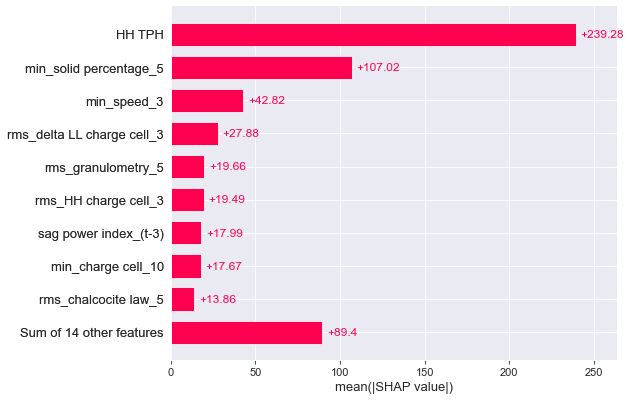

In [23]:
# Bar plot
shap.plots.bar(shap_values)

In [31]:
tag_select

['min_solid percentage_5',
 'min_speed_3',
 'HH TPH',
 'max_delta LL charge cell_10',
 'rms_delta LL charge cell_3',
 'rms_ball work index_10',
 'rms_HH charge cell_3',
 'sag power index_(t-3)',
 'max_bornite law_10',
 'rms_chalcocite law_5',
 'var_delta HH charge cell_5',
 'pyrite law_(t-4)',
 'rms_delta HH charge cell_3',
 'crusher index_(t-3)',
 'Edad',
 'rms_granulometry_5',
 'var_bornite law_3',
 'var_ball work index_3',
 'covelin law_(t-5)',
 'min_charge cell_10',
 'min_chalcopyrite law_10',
 'var_solid percentage_3',
 'var_speed_10']

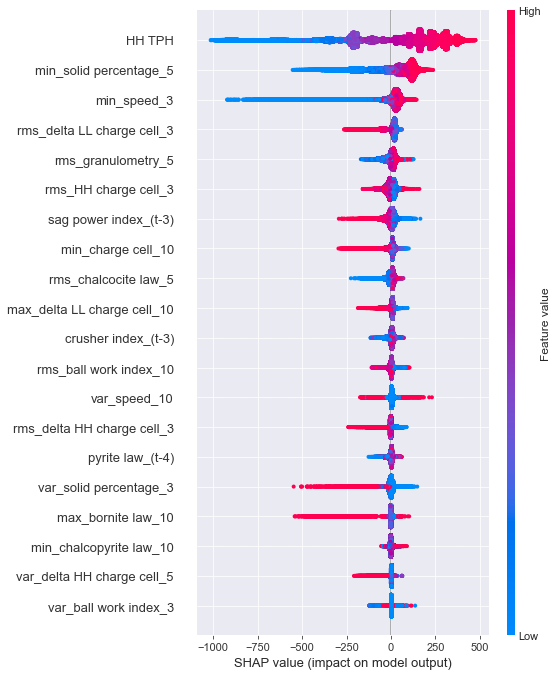

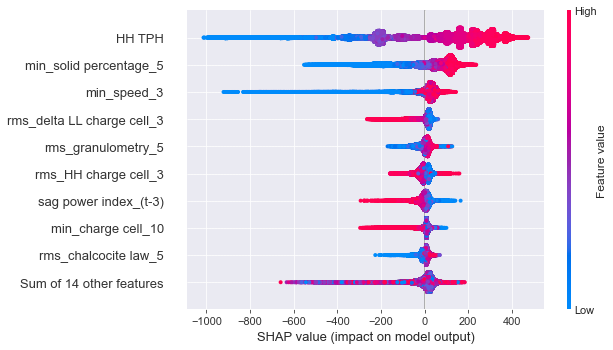

In [24]:
# Summary plot: beeswarm
shap.summary_plot(shap_values)
# or 
shap.plots.beeswarm(shap_values)

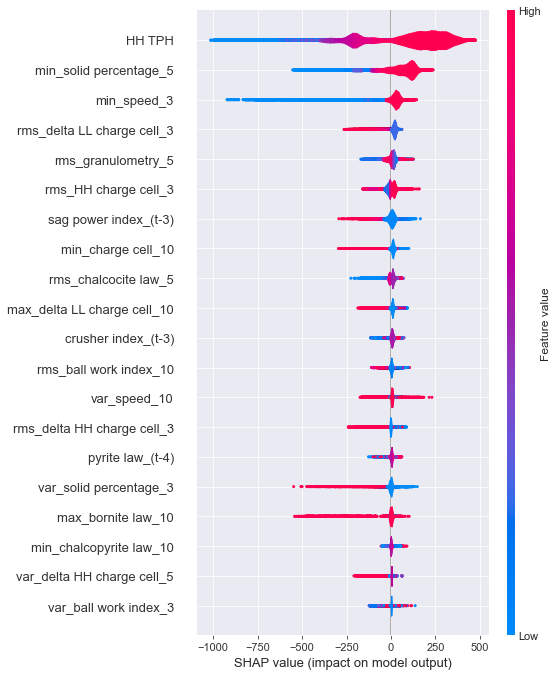

In [25]:
# Summary plot: violin
shap.summary_plot(shap_values, plot_type='violin')

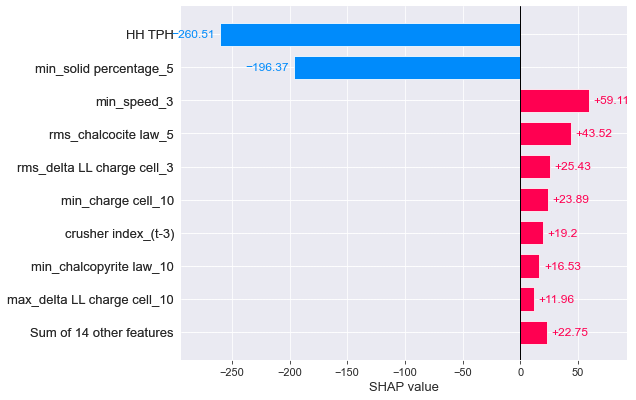

In [26]:
# Local bar plot
shap.plots.bar(shap_values[0])

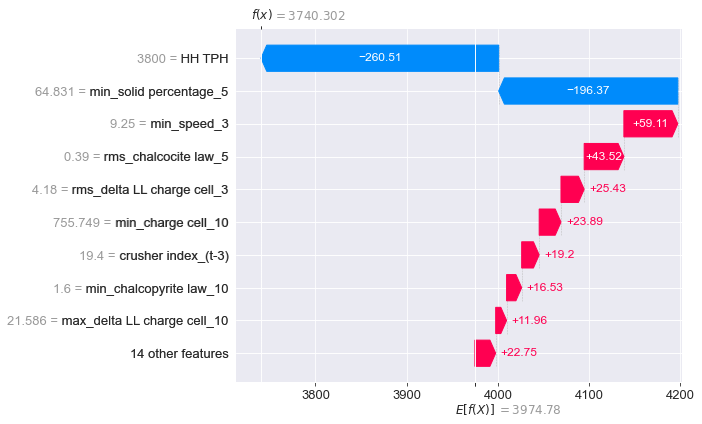

In [27]:
# Waterfall plot
shap.plots.waterfall(shap_values[0])

In [28]:
# Force plot
shap.initjs()
shap.plots.force(shap_values[0])

# Simulation time series predict

# 2020

In [ ]:
# test 2021
test_time_serie=Xtest["2020"]
test_time_serie["TPH"]=Ytest["2020"]
test_time_serie["TPH predict"]=pipe.predict(test_time_serie)


# Métricas
print('R2: ',r2_score(test_time_serie["TPH"], test_time_serie["TPH predict"]),'\n','RMSE: ',mean_squared_error(test_time_serie["TPH"], test_time_serie["TPH predict"], squared=False))
test_time_serie["TPH"]=test_time_serie["TPH"].shift(10)
test_time_serie.dropna(inplace=True)
data=test_time_serie
data.head(1)

In [ ]:
titulos=tuple(["TPH & HH TPH", "charge cell","granulometry","SPI","speed","solid percentage"])
fig = make_subplots(
    rows=6, cols=1,
    subplot_titles=titulos,
    #subplot_titles=tuple("TPH y HH TPH,"),
     shared_xaxes=True
    )


fig.add_trace(go.Scatter(x=data.index, y=data['TPH'], ##FF6511
                    mode='lines',
                    name="TPH",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['TPH predict'], ##FF6511
                    mode='lines',
                    name="TPH predict",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['HH TPH'], ##FF6511
                    mode='lines',
                    name="HH TPH",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

#fig.add_trace(go.Scatter(x=data.index, y=data["TPH predict"], ##FF6511
#                    mode='lines',
#                    name="regressor model TPH",line=dict(width=1,color="black" ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['HH charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1) 

fig.add_trace(go.Scatter(x=data.index, y=data['LL charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1)   

fig.add_trace(go.Scatter(x=data.index, y=data['granulometry'], ##FF6511
                    mode='lines',
                    name='granulometry',line=dict(width=3,),legendgroup = '1'),row=3, col=1)  


fig.add_trace(go.Scatter(x=data.index, y=data['sag power index'], ##FF6511
                    mode='lines',
                    name="sag power index",line=dict(width=3, ),legendgroup = '1'),row=4, col=1)  



fig.add_trace(go.Scatter(x=data.index, y=data['speed'], ##FF6511
                    mode='lines',
                    name="speed",line=dict(width=3, ),legendgroup = '1'),row=5, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['solid percentage'], ##FF6511
                    mode='lines',
                    name='solid percentage',line=dict(width=3, ),legendgroup = '1'),row=6, col=1)  


#for i in range(1,6):
#   for j in range(1,4):
#        fig.update_xaxes(tickformat="%H:%M",row=i, col=j)


fig.update_layout(height=1000, width=1500, title_text="Temporal signal analysis")
fig.update_layout(hovermode="x unified")
#

fig.show()

In [ ]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data["TPH"],
                    mode='lines',
                    name='TPH'))
fig.add_trace(go.Scatter(x=data.index, y=data["TPH predict"],
                    mode='lines',
                    name='TPH predict'))

fig.add_trace(go.Scatter(x=data.index, y=data["HH TPH"],
                    mode='lines',
                    name='HH TPH'))

fig.update_layout(height=500, width=1200, title_text="TPH vs TPH predict"#,xaxis6_rangeslider_visible=True
,#template="plotly_dark"
)                   
fig.show()

In [36]:
fig.write_html("file.html")

# 2021

In [ ]:
# test 2021
test_time_serie=Xtest["2021"]
test_time_serie["TPH"]=Ytest["2021"]
test_time_serie["TPH predict"]=pipe.predict(test_time_serie)


# Métricas
print('R2: ',r2_score(test_time_serie["TPH"], test_time_serie["TPH predict"]),'\n','RMSE: ',mean_squared_error(test_time_serie["TPH"], test_time_serie["TPH predict"], squared=False))
test_time_serie["TPH"]=test_time_serie["TPH"].shift(10)
test_time_serie.dropna(inplace=True)
data=test_time_serie
data.head(1)

In [ ]:
titulos=tuple(["TPH & HH TPH", "charge cell","granulometry","SPI","speed","solid percentage"])
fig = make_subplots(
    rows=6, cols=1,
    subplot_titles=titulos,
    #subplot_titles=tuple("TPH y HH TPH,"),
     shared_xaxes=True
    )


fig.add_trace(go.Scatter(x=data.index, y=data['TPH'], ##FF6511
                    mode='lines',
                    name="TPH",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['TPH predict'], ##FF6511
                    mode='lines',
                    name="TPH predict",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['HH TPH'], ##FF6511
                    mode='lines',
                    name="HH TPH",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

#fig.add_trace(go.Scatter(x=data.index, y=data["TPH predict"], ##FF6511
#                    mode='lines',
#                    name="regressor model TPH",line=dict(width=1,color="black" ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['HH charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1) 

fig.add_trace(go.Scatter(x=data.index, y=data['LL charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1)   

fig.add_trace(go.Scatter(x=data.index, y=data['granulometry'], ##FF6511
                    mode='lines',
                    name='granulometry',line=dict(width=3,),legendgroup = '1'),row=3, col=1)  


fig.add_trace(go.Scatter(x=data.index, y=data['sag power index'], ##FF6511
                    mode='lines',
                    name="sag power index",line=dict(width=3, ),legendgroup = '1'),row=4, col=1)  



fig.add_trace(go.Scatter(x=data.index, y=data['speed'], ##FF6511
                    mode='lines',
                    name="speed",line=dict(width=3, ),legendgroup = '1'),row=5, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['solid percentage'], ##FF6511
                    mode='lines',
                    name='solid percentage',line=dict(width=3, ),legendgroup = '1'),row=6, col=1)  


#for i in range(1,6):
#   for j in range(1,4):
#        fig.update_xaxes(tickformat="%H:%M",row=i, col=j)


fig.update_layout(height=1000, width=1500, title_text="Temporal signal analysis")
fig.update_layout(hovermode="x unified")
#

fig.show()

In [ ]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data["TPH"],
                    mode='lines',
                    name='TPH'))
fig.add_trace(go.Scatter(x=data.index, y=data["TPH predict"],
                    mode='lines',
                    name='TPH predict'))

fig.add_trace(go.Scatter(x=data.index, y=data["HH TPH"],
                    mode='lines',
                    name='HH TPH'))

fig.update_layout(height=500, width=1200, title_text="TPH vs TPH predict"#,xaxis6_rangeslider_visible=True
,#template="plotly_dark"
)                   
fig.show()

# 2022

In [ ]:
# test 2022-01
test_time_serie=Xtest["2022-01"]
test_time_serie["TPH"]=Ytest["2022-01"]
test_time_serie["TPH predict"]=pipe.predict(test_time_serie)


# Métricas
print('R2: ',r2_score(test_time_serie["TPH"], test_time_serie["TPH predict"]),'\n','RMSE: ',mean_squared_error(test_time_serie["TPH"], test_time_serie["TPH predict"], squared=False))
test_time_serie["TPH"]=test_time_serie["TPH"].shift(10)
test_time_serie.dropna(inplace=True)
data=test_time_serie
data.head(1)

In [ ]:
titulos=tuple(["TPH & HH TPH", "charge cell","granulometry","SPI","speed","solid percentage"])
fig = make_subplots(
    rows=6, cols=1,
    subplot_titles=titulos,
    #subplot_titles=tuple("TPH y HH TPH,"),
     shared_xaxes=True
    )


fig.add_trace(go.Scatter(x=data.index, y=data['TPH'], ##FF6511
                    mode='lines',
                    name="TPH",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['TPH predict'], ##FF6511
                    mode='lines',
                    name="TPH predict",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['HH TPH'], ##FF6511
                    mode='lines',
                    name="HH TPH",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

#fig.add_trace(go.Scatter(x=data.index, y=data["TPH predict"], ##FF6511
#                    mode='lines',
#                    name="regressor model TPH",line=dict(width=1,color="black" ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['HH charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1) 

fig.add_trace(go.Scatter(x=data.index, y=data['LL charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1)   

fig.add_trace(go.Scatter(x=data.index, y=data['granulometry'], ##FF6511
                    mode='lines',
                    name='granulometry',line=dict(width=3,),legendgroup = '1'),row=3, col=1)  


fig.add_trace(go.Scatter(x=data.index, y=data['sag power index'], ##FF6511
                    mode='lines',
                    name="sag power index",line=dict(width=3, ),legendgroup = '1'),row=4, col=1)  



fig.add_trace(go.Scatter(x=data.index, y=data['speed'], ##FF6511
                    mode='lines',
                    name="speed",line=dict(width=3, ),legendgroup = '1'),row=5, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['solid percentage'], ##FF6511
                    mode='lines',
                    name='solid percentage',line=dict(width=3, ),legendgroup = '1'),row=6, col=1)  


#for i in range(1,6):
#   for j in range(1,4):
#        fig.update_xaxes(tickformat="%H:%M",row=i, col=j)


fig.update_layout(height=1000, width=1500, title_text="Temporal signal analysis")
fig.update_layout(hovermode="x unified")
#

fig.show()

In [ ]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data["TPH"],
                    mode='lines',
                    name='TPH'))
fig.add_trace(go.Scatter(x=data.index, y=data["TPH predict"],
                    mode='lines',
                    name='TPH predict'))

fig.add_trace(go.Scatter(x=data.index, y=data["HH TPH"],
                    mode='lines',
                    name='HH TPH'))

fig.update_layout(height=500, width=1200, title_text="TPH vs TPH predict"#,xaxis6_rangeslider_visible=True
,#template="plotly_dark"
)                   
fig.show()

In [ ]:
# test 2022-02
test_time_serie=Xtest["2022-02"]
test_time_serie["TPH"]=Ytest["2022-02"]
test_time_serie["TPH predict"]=pipe.predict(test_time_serie)


# Métricas
print('R2: ',r2_score(test_time_serie["TPH"], test_time_serie["TPH predict"]),'\n','RMSE: ',mean_squared_error(test_time_serie["TPH"], test_time_serie["TPH predict"], squared=False))
test_time_serie["TPH"]=test_time_serie["TPH"].shift(10)
test_time_serie.dropna(inplace=True)
data=test_time_serie
data.head(1)

In [ ]:
titulos=tuple(["TPH & HH TPH", "charge cell","granulometry","SPI","speed","solid percentage"])
fig = make_subplots(
    rows=6, cols=1,
    subplot_titles=titulos,
    #subplot_titles=tuple("TPH y HH TPH,"),
     shared_xaxes=True
    )


fig.add_trace(go.Scatter(x=data.index, y=data['TPH'], ##FF6511
                    mode='lines',
                    name="TPH",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['TPH predict'], ##FF6511
                    mode='lines',
                    name="TPH predict",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['HH TPH'], ##FF6511
                    mode='lines',
                    name="HH TPH",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

#fig.add_trace(go.Scatter(x=data.index, y=data["TPH predict"], ##FF6511
#                    mode='lines',
#                    name="regressor model TPH",line=dict(width=1,color="black" ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['HH charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1) 

fig.add_trace(go.Scatter(x=data.index, y=data['LL charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1)   

fig.add_trace(go.Scatter(x=data.index, y=data['granulometry'], ##FF6511
                    mode='lines',
                    name='granulometry',line=dict(width=3,),legendgroup = '1'),row=3, col=1)  


fig.add_trace(go.Scatter(x=data.index, y=data['sag power index'], ##FF6511
                    mode='lines',
                    name="sag power index",line=dict(width=3, ),legendgroup = '1'),row=4, col=1)  



fig.add_trace(go.Scatter(x=data.index, y=data['speed'], ##FF6511
                    mode='lines',
                    name="speed",line=dict(width=3, ),legendgroup = '1'),row=5, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['solid percentage'], ##FF6511
                    mode='lines',
                    name='solid percentage',line=dict(width=3, ),legendgroup = '1'),row=6, col=1)  


#for i in range(1,6):
#   for j in range(1,4):
#        fig.update_xaxes(tickformat="%H:%M",row=i, col=j)


fig.update_layout(height=1000, width=1500, title_text="Temporal signal analysis")
fig.update_layout(hovermode="x unified")
#

fig.show()

In [ ]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data["TPH"],
                    mode='lines',
                    name='TPH'))
fig.add_trace(go.Scatter(x=data.index, y=data["TPH predict"],
                    mode='lines',
                    name='TPH predict'))

fig.add_trace(go.Scatter(x=data.index, y=data["HH TPH"],
                    mode='lines',
                    name='HH TPH'))

fig.update_layout(height=500, width=1200, title_text="TPH vs TPH predict"#,xaxis6_rangeslider_visible=True
,#template="plotly_dark"
)                   
fig.show()